### we define a model for our simulated data and generate it for a time window

In [19]:
import george
import emcee
# import corner


In [20]:
from george.modeling import Model

class Model(Model):
    parameter_names = ("amp", "location", "log_sigma2")

    def get_value(self, t):
        return self.amp * np.exp(-0.5*(t.flatten()-self.location)**2 * np.exp(-self.log_sigma2))


In [21]:
import numpy as np
import matplotlib.pyplot as pl
from george import kernels

np.random.seed(1234) # gives same randomess each time

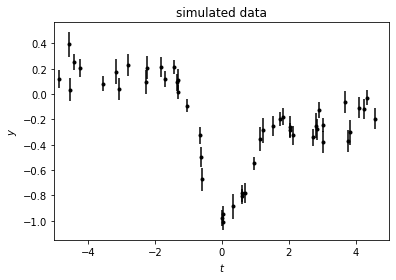

In [22]:
def generate_data(params, N, rng=(-5, 5)):
    gp = george.GP(0.1 * kernels.ExpSquaredKernel(3.3))
    t = rng[0] + np.diff(rng) * np.sort(np.random.rand(N))  # changes every time
    y = gp.sample(t)  # also changes every time
    y += Model(**params).get_value(t)        # adds onto previous every time
    yerr = 0.05 + 0.05 * np.random.rand(N)   # 50x1 array of normal distribution of randoms from 0 to 0.05
    y += yerr * np.random.randn(N)           # adds correlated noise (correlated b/c of random seed??)
    return t, y, yerr

truth = dict(amp=-1.0, location=0.1, log_sigma2=np.log(0.4))
t, y, yerr = generate_data(truth, 50)

pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
pl.ylabel(r"$y$")
pl.xlabel(r"$t$")
pl.xlim(-5, 5)
pl.title("simulated data");


In [23]:
class PolynomialModel(Model):
    parameter_names = ("m", "b", "amp", "location", "log_sigma2")

    def get_value(self, t):
        t = t.flatten()
        return (t * self.m + self.b +
                self.amp * np.exp(-0.5*(t-self.location)**2*np.exp(-self.log_sigma2)))


#### We invent a model

In [40]:
class LinearModel(Model):
    parameter_names = ("m", "b")
    
    def get_value(self, t):
        t = t.flatten()
        return (t * self.m + self.b)
        

#### We choose priors 

In [32]:
prior_m = 0 # -0.05
prior_b = 0 # 1
model = george.GP(mean=PolynomialModel(m=prior_m, b=prior_b,
                                      amp=-1, location=0.1, log_sigma2=np.log(0.4)))

model.compute(t, yerr)

# combine model w/priors with likelihood function
def lnprob(p):
    model.set_parameter_vector(p)
    return model.log_likelihood(y, quiet=True) + model.log_prior()


In [33]:
# initialize the walkers
initial = model.get_parameter_vector()
ndim, nwalkers = len(initial), 32
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 500)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 1000);

Running burn-in...
Running production...


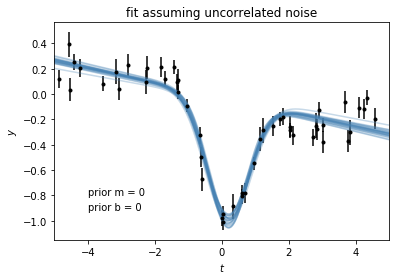

In [34]:
# Plot the data.
pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

# The positions where the prediction should be computed.
x = np.linspace(-5, 5, 500)

# Plot 24 randomly selected posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    model.set_parameter_vector(s)
    pl.plot(x, model.mean.get_value(x), color="#4682b4", alpha=0.3)

pl.ylabel(r"$y$")
pl.xlabel(r"$t$")
pl.xlim(-5, 5)
pl.text(-4,-0.8,f"prior m = {prior_m}")
pl.text(-4,-0.92,f"prior b = {prior_b}")
pl.title("fit assuming uncorrelated noise");
pl.savefig(f"fit_m{prior_m}_b{prior_b}.png",bbox_inches="tight")

#### Now we do the same, assuming the noise is correlated

In [18]:
kernels.Matern32Kernel(10.0)

Matern32Kernel(metric=Metric(10.000000000000002, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None)

In [6]:
truth

{'amp': -1.0, 'location': 0.1, 'log_sigma2': -0.916290731874155}

In [41]:
prior_m = 0
prior_b = 1000

kwargs = dict(**truth)
kwargs["bounds"] = dict(location=(-2, 2))
# mean_model = Model(**kwargs)
mean_model = LinearModel(m=prior_m, b=prior_b)
gp = george.GP(np.var(y) * kernels.Matern32Kernel(10.0), mean=mean_model)
gp.compute(t, yerr)

def lnprob2(p):
    gp.set_parameter_vector(p)
    return gp.log_likelihood(y, quiet=True) + gp.log_prior()


In [42]:
initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2)

print("Running first burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 200) # 2000)

print("Running second burn-in...")
p0 = p0[np.argmax(lp)] + 1e-8 * np.random.randn(nwalkers, ndim)
sampler.reset()
p0, _, _ = sampler.run_mcmc(p0, 200) # 2000)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 200); # 2000);

print("Done")

Running first burn-in...
Running second burn-in...
Running production...
Done


/Users/nmg/anaconda3/lib/python3.7/site-packages/george/utils.py:30: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mean, matrix, N)


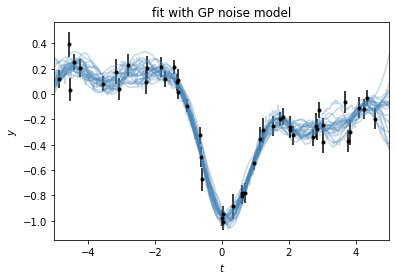

In [43]:
# Plot the data.
pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

# The positions where the prediction should be computed.
x = np.linspace(-5, 5, 500)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s)
    mu = gp.sample_conditional(y, x)
    pl.plot(x, mu, color="#4682b4", alpha=0.3)

pl.ylabel(r"$y$")
pl.xlabel(r"$t$")
pl.xlim(-5, 5)
#pl.text(-4,-0.8,f"prior m = {prior_m}")
#pl.text(-4,-0.92,f"prior b = {prior_b}")
pl.title("fit with GP noise model");
#pl.savefig(f"correlatednoisefit_m{prior_m}_b{prior_b}.png",bbox_inches="tight")